<a href="https://colab.research.google.com/github/mukund-rajukumar/My-VisionAI-Projects/blob/main/FoodAndBevPackageDetection/Detection_HybridMode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#@title Install Dependencies
import importlib.util # Import the importlib module

if importlib.util.find_spec('tabulate') is None:
  %pip install tabulate

if importlib.util.find_spec('timm') is None:
  %pip install timm

if importlib.util.find_spec('torch') is None:
  %pip install torch

if importlib.util.find_spec('openai') is None:
  %pip install openai
from openai import OpenAI

# Setup genAI model to generate label for images
if importlib.util.find_spec('google-generativeai') is None:
  %pip install google-generativeai
import google.generativeai as genai

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import numpy as np
import os
import yaml
import time
import re
import pandas as pd

import torch

import math
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode

from pathlib import Path

import requests, base64, io

import transformers
#from transformers import AutoTokenizer, AutoModel
from transformers import MllamaForConditionalGeneration, AutoProcessor


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.2.3/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
#@title Set API Access Tokens for OpenAI and HuggingFace
if os.environ.get('HOME') == "/Users/mukund" or os.environ.get('HOME') == "/Users/Mukund":
  import json
  %cd '/Users/mukund/Documents/HealthyYouVendingProject'
  print("Warning: Not running in Google Colab. Some functionalities may be limited.")
  with open('credentials.json', 'r') as f:  # Open the file in read mode ('r')
    credentials = json.load(f)
  openai_api_key = credentials['OPENAI-API-KEY']
  hf_token=credentials['HF-W-TOKEN']
  google_api_key = credentials['GOOGLE_API_KEY']
else:
  import google.colab
  from google.colab import userdata
  openai_api_key = userdata.get('OPENAI-API-KEY')
  hf_token=userdata.get('HF-W-TOKEN')
  google_api_key=userdata.get('GOOGLE_API_KEY')

/Users/mukund/Documents/HealthyYouVendingProject


In [13]:
#@title Function: Load class names from yaml file

def load_class_labels(yaml_path):
  """Loads class labels from a YAML file.

  Args:
      yaml_path (str): The path to the YAML file containing the class labels.

  Returns:
      list: A list of class labels.
  """

  with open(yaml_path, 'r') as file:
    data = yaml.safe_load(file)
  return data['names']  # 'names' contains the list of class labels

In [14]:
#@title Function: Extract bounding boxes and class names from Yolo format test data and overlay on image

def extract_and_plot_image_bboxes(img, label_path, class_labels):
  """Extracts bounding boxes and class labels from a label file and plots them on an image.

  Args:
      img (Image.Image): The image to plot the bounding boxes on.
      label_path (str): The path to the label file containing bounding box information.
      class_labels (list): A list of class labels corresponding to the class IDs in the label file.

  Returns:
      list: A list of dictionaries containing extracted image label information (class ID and bounding box coordinates).

  Raises:
      ValueError: If the label file format is invalid (expected format: class_id x_center y_center width height per line).
  """

  # Create a plot
  fig, ax = plt.subplots(1, figsize=(10, 10))
  ax.imshow(img)

  # Read the label file and extract bounding boxes
  image_labels = []
  try:
    with open(label_path, 'r') as f:
      for line in f.readlines():
        class_id, x_center, y_center, width, height = map(float, line.split())
        # Convert normalized coordinates to absolute pixel values
        x1n = (x_center - width / 2)
        y1n = (y_center - height / 2)
        x2n = (x_center + width / 2)
        y2n = (y_center + height / 2)
        image_labels.append({'class_id': class_id, 'bbox': (x1n, y1n, x2n, y2n)})
  except ValueError:
    raise ValueError(f"Invalid label file format. Expected format: class_id x_center y_center width height per line.")

  # Plot bounding boxes and labels
  for image_label in image_labels:
    class_id = image_label['class_id']
    x1n, y1n, x2n, y2n = image_label['bbox']
    img_w, img_h = img.size
    width_abs = (x2n - x1n) * img_w
    height_abs = (y2n - y1n) * img_h
    x_min = x1n * img_w
    y_min = y1n * img_h

    # Create a rectangle patch for the bounding box
    rect = patches.Rectangle((x_min, y_min), width_abs, height_abs, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Optionally, annotate the class label
    ax.text(x_min, y_min, class_labels[class_id], color='white', fontsize=12, bbox=dict(facecolor='r', edgecolor='r'))

  # Show the plot
  plt.show()
  return image_labels

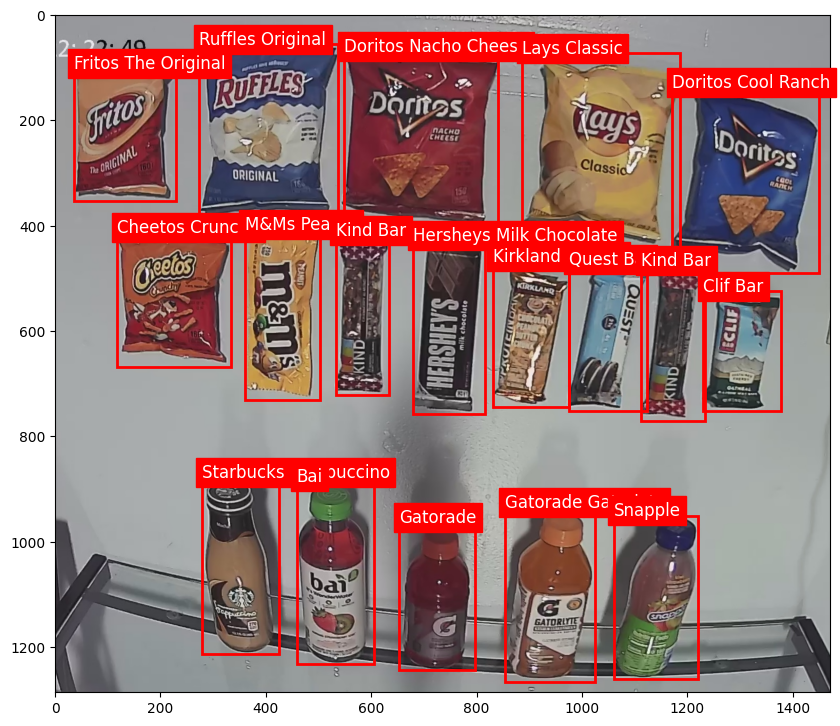

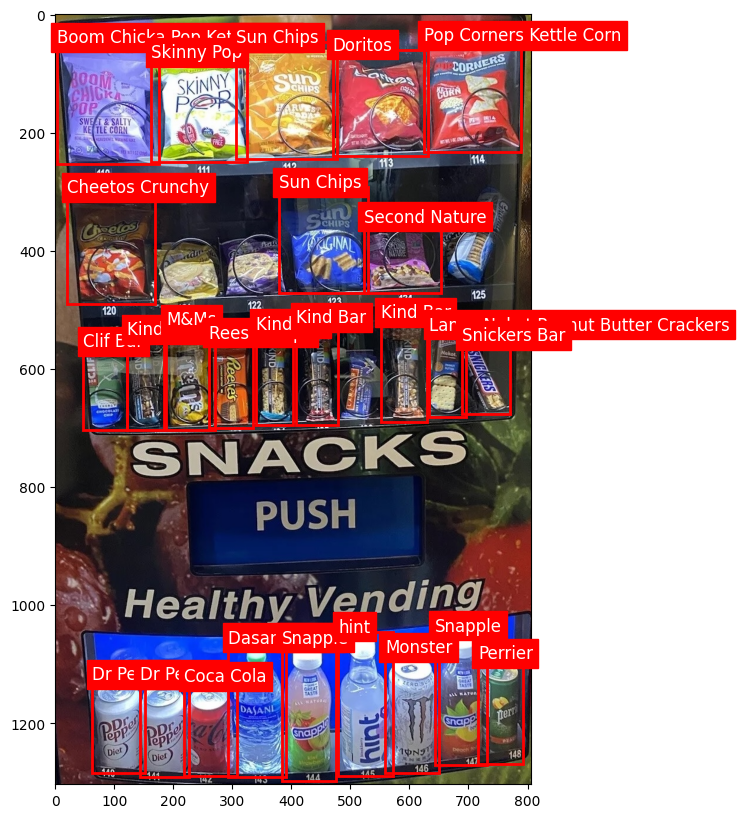

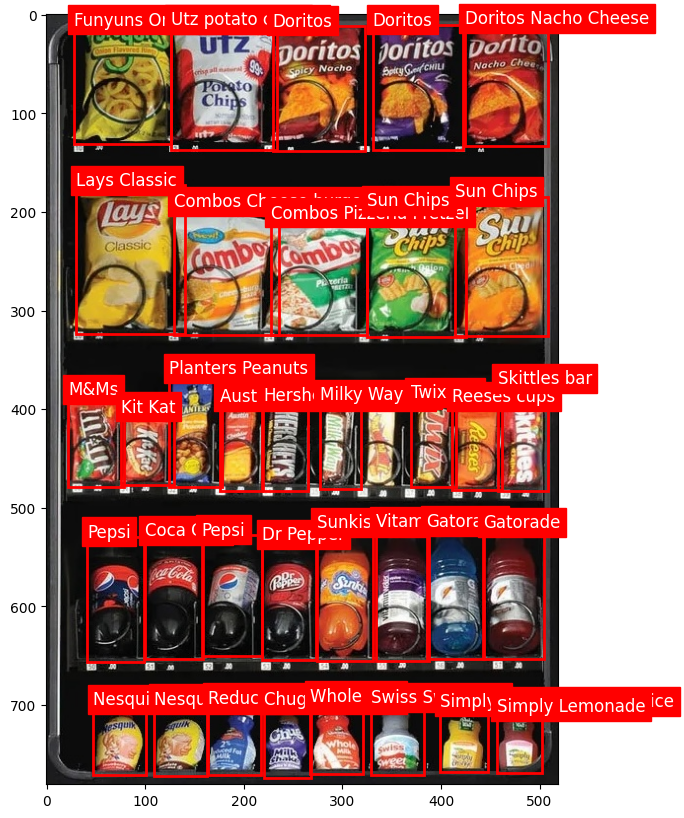

In [15]:
#@title Load Test Data
# In general, use ! if the command is one that's okay to run in a separate shell.
# Use % if the command needs to be run on the specific notebook.
if os.environ.get('HOME') == "/Users/mukund" or os.environ.get('HOME') == "/Users/Mukund":
  dataset_dir = './fnb-dataset'
else:
  dataset_dir = '.'

# Define paths to the dataset
images_dir = os.path.join(dataset_dir, 'images')
labels_dir = os.path.join(dataset_dir, 'labels')
data_yaml_path = os.path.join(dataset_dir, 'data.yaml')

# Load class labels from the data.yaml file
class_labels = load_class_labels(data_yaml_path)

# List of image files
image_files = os.listdir(images_dir)
num_images = len(image_files)

# Loop through the test images and plot them with their bounding boxes
test_data = []
for image_file in image_files:
  image_path = os.path.join(images_dir, image_file)
  if (image_file == '.DS_Store'):
    continue
  image = Image.open(image_path)
  # print(f"{img_fname} dim: {images[-1].size}")
  label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))  # Assuming the labels have the same name as the images
  labels = extract_and_plot_image_bboxes(image, label_path, class_labels)
  test_data.append({'image': image, 'filename': image_file, 'labels': labels})

In [60]:
#@title Load Model
genai.configure(api_key=google_api_key)

# Gemini-1.5-Flash probably a 32B param model, 1.5-Pro a 120B param model
#gemini_model = genai.GenerativeModel('gemini-1.5-flash')
gemini_model = genai.GenerativeModel('gemini-1.5-pro')

img_desc_prompt = "This image shows multiple packaged food and beverage products. Return the bounding boxes around each product in [ymin, xmin, ymax, xmax] in json format"
llm_responses_pro = []
for test_sample in test_data:
  image = test_sample['image']
  image_fname = test_sample['filename']
  print(image_fname)
  llm_response = gemini_model.generate_content([img_desc_prompt, image])
  print(llm_response.usage_metadata)
  text_content = getattr(llm_response, "text")
  print(gemini_model.model_name)
  print(text_content)
  pred_labels = [] #extract_pred_labels(text_content, image)
  llm_responses_pro.append({'prompt': img_desc_prompt, 'model': gemini_model, 'response': llm_response, 'ref_labels': test_sample['labels'], 'pred_labels': pred_labels, 'image_fname': image_fname})



vending2.jpg
prompt_token_count: 289
candidates_token_count: 495
total_token_count: 784

models/gemini-1.5-pro
```json
[
  [
    87,
    35,
    305,
    148
  ],
  [
    48,
    183,
    313,
    346
  ],
  [
    53,
    373,
    358,
    571
  ],
  [
    82,
    615,
    368,
    788
  ],
  [
    135,
    806,
    403,
    967
  ],
  [
    351,
    78,
    475,
    207
  ],
  [
    353,
    231,
    531,
    317
  ],
  [
    361,
    354,
    526,
    393
  ],
  [
    365,
    441,
    538,
    576
  ],
  [
    389,
    589,
    535,
    654
  ],
  [
    393,
    683,
    546,
    756
  ],
  [
    413,
    783,
    558,
    903
  ],
  [
    665,
    194,
    936,
    275
  ],
  [
    683,
    319,
    940,
    395
  ],
  [
    733,
    426,
    975,
    499
  ],
  [
    718,
    596,
    980,
    687
  ],
  [
    716,
    726,
    984,
    813
  ]
]
```

vending5-1.jpg
prompt_token_count: 289
candidates_token_count: 1768
total_token_count: 2057

models/gemini-1.5-pro
```json
[
  {
  

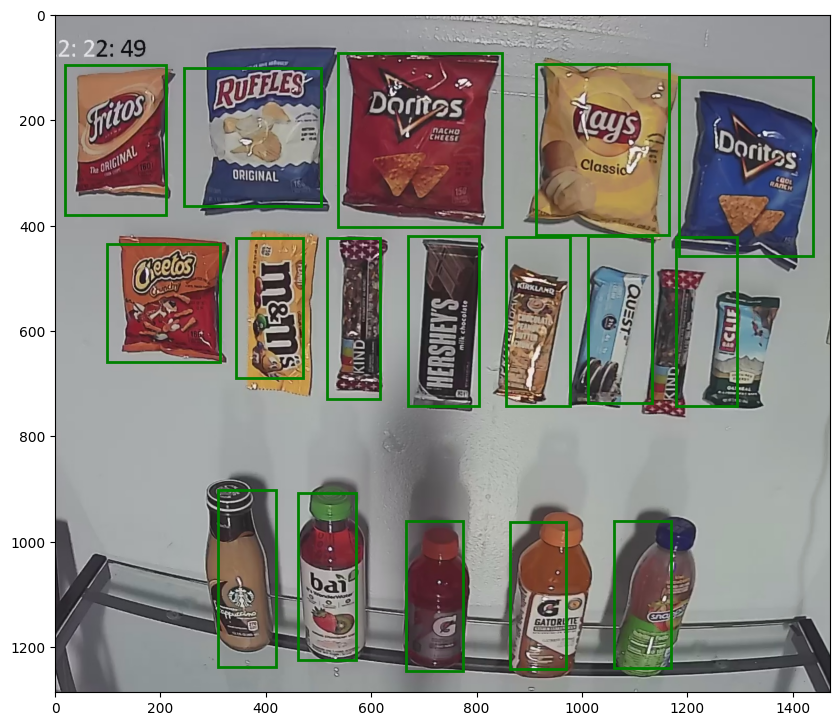

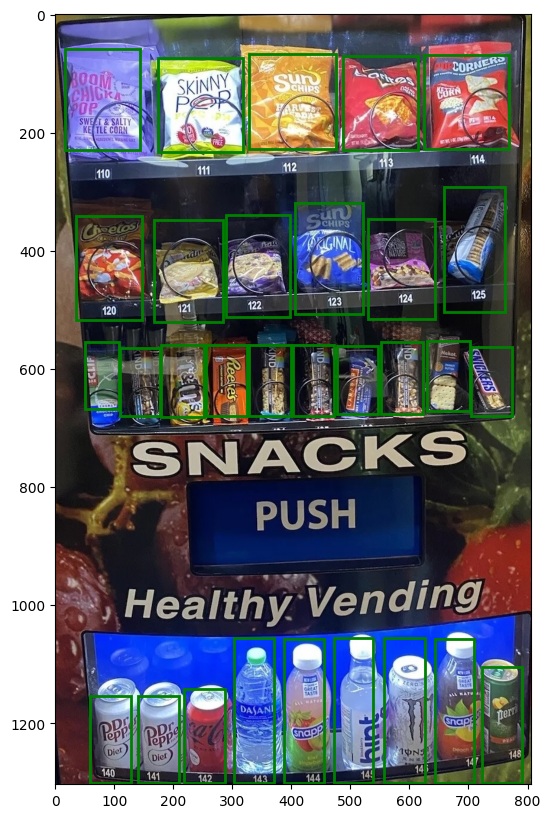

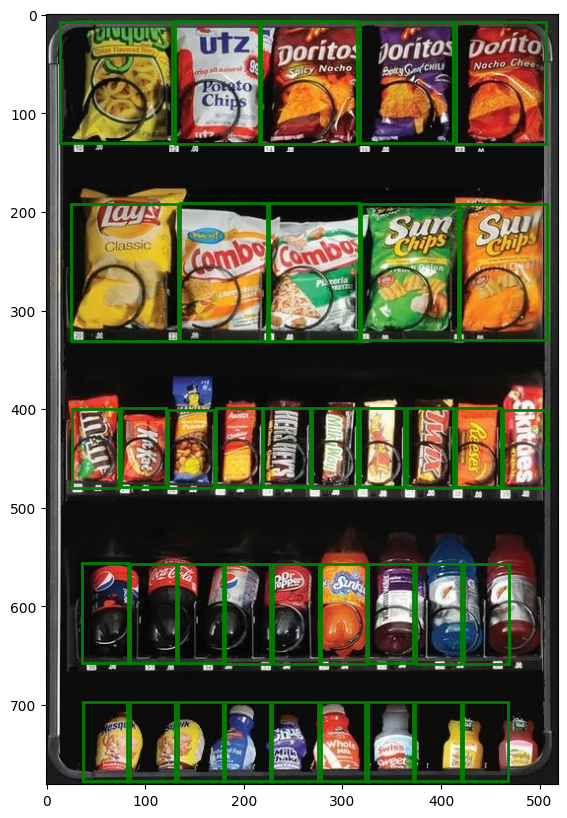

In [58]:
for llm_response in llm_responses:
  text_content = getattr(llm_response['response'],"text")
  json_string = text_content.replace("json", "")
  json_string = json_string.replace("```", "")

  # Convert JSON string to Python list of dictionaries
  json_data = json.loads(json_string)

  # Print the result to verify
  #print(json_data)

  bounding_boxes = [(item["xmin"], item["ymin"], item["xmax"], item["ymax"]) for item in json_data]

  fname = llm_response['image_fname']
  if fname == "vending2.jpg": ind = 0
  if fname == "vending5-1.jpg": ind = 1
  if fname == "vending3-1.jpg": ind = 2

  image = test_data[ind]['image']

  plot_bboxes(image, bounding_boxes)





In [56]:
def plot_bboxes(image, bounding_boxes):

  # Plot the image with classification info overlaid
  width, height = image.size

  # Create figure and axes
  fig, ax = plt.subplots(1, figsize=(10, 10))

  # Display the image
  ax.imshow(image)

  # Plot the bounding boxes
  for bbox in bounding_boxes:
    # Denormalize the bounding box to image size
    x1, y1, x2, y2 = bbox
#    print(x1,x2,y1,y2)

    x1 = int((x1/1000) * width)
    x2 = int((x2/1000) * width)
    y1 = int((y1/1000) * height)
    y2 = int((y2/1000) * height)

    # Create a rectangle
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
    # Add the rectangle to the plot
    ax.add_patch(rect)

  # Show the plot
  plt.show()